<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/Fastai%2BTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Started

In [1]:
!pip install transformers

     |████████████████████████████████| 368kB 6.6MB/s 
     |████████████████████████████████| 1.0MB 44.3MB/s 
     |████████████████████████████████| 645kB 37.3MB/s 
     |████████████████████████████████| 860kB 37.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=04ec0f4717a98ee64eb2fa49e746ea3aecc25c00407e5279a57692b8496e629e
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [2]:
import fastai
import transformers
print(f'fastai version: {fastai.__version__}')
print(f'transformers version: {transformers. __version__}')

fastai version: 1.0.59
transformers version: 2.2.1


In [0]:
import numpy as np
import pandas as pd
from pathlib import Path

import os

import torch
import torch.optim as optim

import random

# fastai
from fastai import *
from fastai.text import *
from fastai.callback import *

# transformer
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig 

In [4]:
torch.cuda.is_available()

True

## Loading the Data

In [0]:
data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"
data = pd.read_csv(data_path)

In [6]:
data.head(2)

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."


In [0]:
# create the binary label
data['label'] = np.where(data['Score'] > 3, '1', '0')

# change score into categorical so it can be the multiclass label
data['Score'] = data['Score'].astype('category')


In [8]:
data.sample()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,label
35687,B00016LA8E,A1GTIV0IUBTOE0,Best stuff on earth,5,18,251972,"""kgremill""",18,1082160000,This is great stuff. All their products are gr...,1


In [0]:
# split the data by timestamp
timesplit = data['Time'].quantile(0.8)

In [10]:
train = data[data['Time'] < timesplit].sample(10000)
test = data[data['Time'] >= timesplit]
train.shape, test.shape

((10000, 11), (20008, 11))

## FASTAI + TRANSFORMER

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [0]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

model_type = 'bert'
pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

# model_type = 'xlm'
# pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [14]:
# all the pretrained model for the specific model_class
model_class.pretrained_model_archive_map

{'distilbert-base-german-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-german-cased-pytorch_model.bin',
 'distilbert-base-multilingual-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-multilingual-cased-pytorch_model.bin',
 'distilbert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-pytorch_model.bin',
 'distilbert-base-uncased-distilled-squad': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-distilled-squad-pytorch_model.bin'}

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

### 1 Setup FASTAI Databunch

In [16]:
# load the pretrained tokenizer
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)

100%|██████████| 231508/231508 [00:00<00:00, 875653.62B/s]


In [17]:
transformer_tokenizer.max_len

512

###### Create Custom FASTAI TOKENIER from pretrained transformer tokenizer

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [0]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [20]:
tokenizer_class.pretrained_vocab_files_map

{'vocab_file': {'distilbert-base-german-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-german-cased-vocab.txt',
  'distilbert-base-multilingual-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt',
  'distilbert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt',
  'distilbert-base-uncased-distilled-squad': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt'}}

###### Create Custom FASTAI Vocab from the pretrained transformer tokenizer

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [0]:
fastai_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

###### Create Custom FASTAI Processor

In [0]:
numericalize_processor = NumericalizeProcessor(vocab=fastai_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


In [0]:
fastai_processor = [tokenize_processor, numericalize_processor]

###### Create Custom FASTAI Databunch

In [25]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [27]:
databunch = (TextList.from_df(train, cols='Text', processor=fastai_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [28]:
databunch.show_batch(10)

text,target
[CLS] this review is for the 24 pack of 3 oz . cans of the wellness brand cat food . < br / > < br / > objective ##ly speaking . . . < br / > the cans are easy to op ##e and they have consistently arrived in excellent condition . there are 24 cans at 3 oz . each . that ' s all i can,1
"[CLS] if you ' re a chip lover , take heart . there are healthy options out there to soothe your craving ##s . r ##w garcia has a soy fl ##ax ##see ##d chip with no trans fat ##s , no g ##lu ##ten , with fiber and omega 3 ##s . < br / > < br / > i ' ve tried many different chip varieties over",1
"[CLS] as a manhattan ##ite , a vegetarian , and someone who takes food very seriously and is always on the lookout for quick , ta ##sty , health ##ful meals , asian cuisine of all stripes comprises a substantial percentage of my diet . i happened upon amazon reviews of this product quite by accident , so sought it out when i was near a gr ##iste ##des ,",1
"[CLS] ingredients : spices , salt , onion , pa ##pr ##ika , garlic , dex ##tro ##se , vegetable oil ( partially hydrogen ##ated soy ##be ##an oil to help protect flavor ) , corn syrup solids , silicon dioxide ( anti ##ca ##king agent ) . < br / > < br / > dad was the plant engineer at ste ##gne ##r food products in cincinnati ,",1
"[CLS] the major difference between the lava ##zza qu ##ali ##ta oro es ##press ##o ( the gold can ) and the lava ##zza italian coffee , caf ##fe es ##press ##o ( the black can ) coffee ##s is that the gold can lava ##zza uses 100 % arabic ##a beans from two different countries and the black can lava ##zza uses 100 % arabic ##a coffee beans from",1
[CLS] i have a very pick ##y older cat . she is probably extra pick ##y because she ' s old and has trouble digest ##ing some cat foods . this one though is her favorite dry food . she begs for it and waits by her bowl one hour before dinner . my other cat also gets very excited about this food . i ' ve found with other,1
[CLS] i ' m on a diet and there are times when i just want something crunch ##y . but i also have high blood pressure so a lot of snacks that i use as a treat are too high - sodium for me . i eat rice cakes with peanut butter or cottage cheese once in a while and i happened to see pop ##chi ##ps on amazon .,1
"[CLS] ai ##ght , y ' all . this stuff is exactly the same as the earth ' s best formula . what e ##b doesn ' t want you to know is that it also contains corn syrup . e ##b ' s ingredient list includes "" glucose syrup solids "" instead of "" corn syrup solids . "" but what they don ' t want you to know",1
"[CLS] if you ' ve tried the natural energy bars , you might be familiar with the flavor and textures you ' ll experience with this bar . < br / > < br / > if you aren ' t . . . expect a dense , soft but dry texture . there ' s the off flavor of something designated as "" health food "" that is commercially",0
"[CLS] folks , move along - - don ' t buy this from these people . they are completely inc ##omp ##ete ##nt . the links showed up ran ##ci ##d , so i refused the order ( but they also took two + weeks to ship this nightmare , and made my whole experience the worst i have had w / amazon in 8 years ) . < br",0


In [29]:
databunch.one_batch()[0].shape

torch.Size([16, 512])

### 2 Setup FASTAI Learner 

###### Create Custom Transformer Model

In [0]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [31]:
config = config_class.from_pretrained(pretrained_model_name)
config

100%|██████████| 492/492 [00:00<00:00, 136698.30B/s]


{
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "is_decoder": false,
  "max_position_embeddings": 512,
  "n_heads": 12,
  "n_layers": 6,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torchscript": false,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [32]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)
custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

100%|██████████| 265481570/265481570 [00:09<00:00, 26752128.15B/s]


###### Create FASTAI Learner Model

In [0]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy, AUROC()])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [34]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           23,440,896 True      
______________________________________________________________________
Embedding            [512, 768]           393,216    True      
______________________________________________________________________
LayerNorm            [512, 768]           1,536      True      
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Dropout              [12, 512, 512]       0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    True      
______________________________________________________________________
Linear               [512, 768]           590,592    True      
_______________________________________

###### Training FASTAI Learner 

In [35]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.74E-04


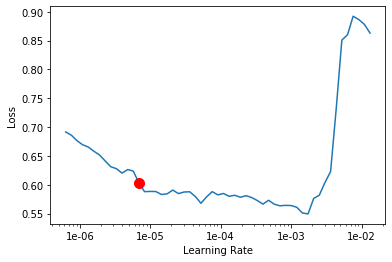

In [36]:
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.242207,0.230776,0.901000,0.952809,04:33


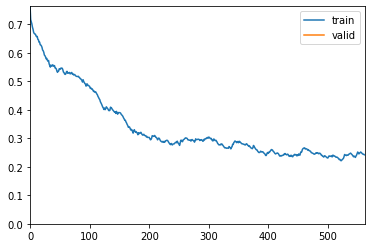

In [37]:
# result for roberta
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.183002,0.220687,0.910000,0.959429,03:38


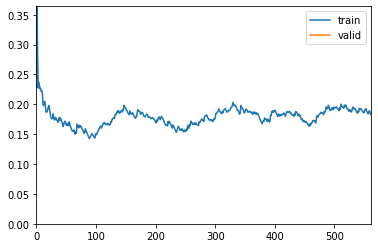

In [38]:
# result for Distilbert
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

In [39]:
learner.show_results(rows=5)

text,target,prediction
"[CLS] after feeding my dogs what i thought was a "" premium brand "" food : ( ia ##ms healthy natural ) , and paying for that as well , i stumbled upon this website : [ . . . ] / and found out how it was actually rated . much to my sadness , the ia ##ms premium food that i had been paying so much for ,",1,0
"[CLS] i like this skill ##et sauce . it has a nice flavor and adds a rich ##ness to ta ##co dishes . the overall flavor is not so very different from < a hr ##ef = "" http : / / www . amazon . com / gp / product / b ##00 ##48 ##if ##vc ##m "" > front ##era pouch , en ##chi ##lad ##a skill ##et",1,1
"[CLS] just bought my first package of these , after reading about this thing in a joe csa ##tar ##i ( sp ? ) book on nutrition . didn ' t know what to expect , but i liked it - - on several accounts . first , if the label is true , it ' s got superior nutritional qualities - - a very good combination of typical nutrients",1,1
"[CLS] last year , i purchased a ke ##uri ##g machine . k - cups are extremely convenient and cleanup is so easy . so many varieties of coffee to choose from and they are generally pretty good . i ' ve tried a number of k - cups since last year and reviewed a few here . fast forward to almost a year later . my ke ##uri ##g",1,1
"[CLS] i have been drinking this tea for about a year , on and off . it is the best green tea that i have tasted . i brew it overnight at room temperature , and i find that it has a full , smooth , and mild flavor . < br / > < br / > another writer stated that the flu ##ori ##de levels associated with this",0,1


In [40]:
interp = learner.interpret(ds_type = DatasetType.Valid)
#txt_ci = TextClassificationInterpretation.from_learner(learner)

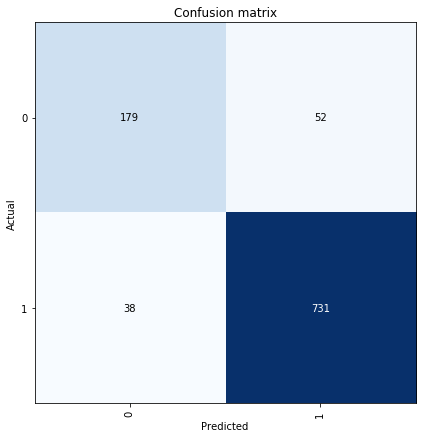

In [41]:
interp.plot_confusion_matrix(normalize=False,figsize=(6,6))

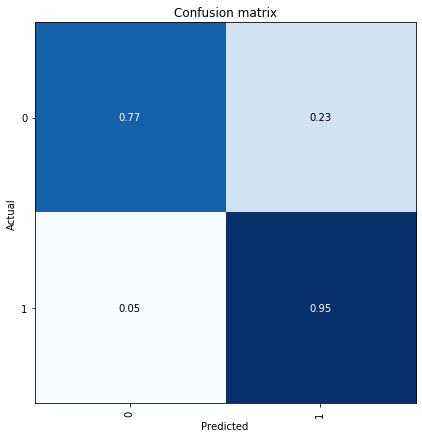

In [42]:
interp.plot_confusion_matrix(normalize=True,figsize=(6,6))

In [43]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [44]:
test['label'].value_counts()

1    15348
0     4660
Name: label, dtype: int64

In [45]:
learner.get_preds(databunch.test_dl)

[tensor([[0.9500, 0.0500],
         [0.0098, 0.9902],
         [0.2972, 0.7028],
         ...,
         [0.9730, 0.0270],
         [0.9730, 0.0270],
         [0.0108, 0.9892]]), tensor([0, 1, 1,  ..., 0, 0, 1])]

In [46]:
databunch.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fa866dcd9e8>, device=device(type='cuda'), tfms=[], collate_fn=functools.partial(<function pad_collate at 0x7fa86979a488>, pad_idx=0, pad_first=False, backwards=False))

### Reference
https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta